✅ Total images: 5722
class
notumor       1595
pituitary     1467
meningioma    1339
glioma        1321
Name: count, dtype: int64
📊 Train: 3890, Val: 687, Test: 1145
Found 3890 validated image filenames belonging to 4 classes.
Found 687 validated image filenames belonging to 4 classes.
Found 1145 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 427ms/step - accuracy: 0.2592 - loss: 1.5091 - val_accuracy: 0.2780 - val_loss: 1.3848 - learning_rate: 0.0010
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 51s 416ms/step - accuracy: 0.2890 - loss: 1.3836 - val_accuracy: 0.2780 - val_loss: 1.3843 - learning_rate: 0.0010
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 51s 418ms/step - accuracy: 0.2769 - loss: 1.3849 - val_accuracy: 0.2780 - val_loss: 1.3837 - learning_rate: 0.0010
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 51s 420ms/step - accuracy: 0.2822 - loss: 1.3836 - val_accuracy: 0.2780 - val_loss: 1.3836 - learning_rate: 0.0010
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 410ms/step - accuracy: 0.2688 - loss: 1.3852 - val_accuracy: 0.2780 - val_loss: 1.3835 - learning_rate: 0.0010
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 439ms/step - accuracy: 0.2902 - loss: 1.3820 - val_accuracy: 0.2780 - val_loss: 1.3835 - learning_rate: 0.0010
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 51s 414ms/step - accuracy: 0.2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


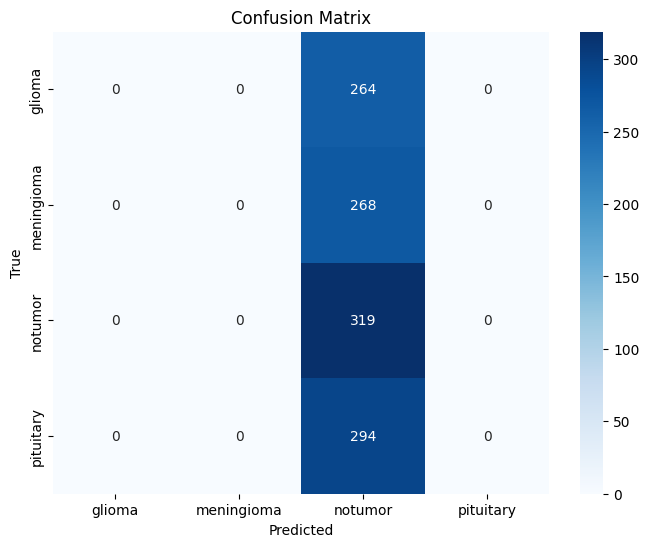

In [8]:
# ✅ Step 1: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns

# ✅ Step 2: Paths & Parameters
DATASET_PATH = "/kaggle/input/harvard-medical-dataset/Harvard_medical_dataset/Training"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50   # more epochs for scratch training

# ✅ Step 3: Load image paths and labels
image_paths, labels = [], []
for class_dir in sorted(os.listdir(DATASET_PATH)):
    class_path = os.path.join(DATASET_PATH, class_dir)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, fname))
                labels.append(class_dir)

df = pd.DataFrame({'filename': image_paths, 'class': labels})
print(f"✅ Total images: {len(df)}")
print(df['class'].value_counts())

# ✅ Step 4: Split into train, val, test
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ✅ Step 5: Create ImageDataGenerators
train_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=15,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                           target_size=IMG_SIZE, class_mode='categorical',
                                           batch_size=BATCH_SIZE)

val_flow = val_test_gen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, class_mode='categorical',
                                            batch_size=BATCH_SIZE)

test_flow = val_test_gen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                             target_size=IMG_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, shuffle=False)

# ✅ Step 6: Build the Model (VGG16 from scratch)
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))  

x = Flatten()(base_model.output)  # VGG16 prefers Flatten instead of GAP
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
num_classes = len(train_flow.class_indices)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ✅ Step 7: Compile
model.compile(optimizer=Adam(learning_rate=1e-3),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Step 8: Train
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ModelCheckpoint("best_vgg16_scratch.keras", save_best_only=True),
    ReduceLROnPlateau(factor=0.2, patience=50, verbose=1)
]

history = model.fit(train_flow,
                    validation_data=val_flow,
                    epochs=EPOCHS,
                    callbacks=callbacks)

# ✅ Step 9: Evaluate
loss, acc = model.evaluate(test_flow)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# ✅ Step 10: Predictions
y_true = test_flow.classes
y_pred = np.argmax(model.predict(test_flow), axis=1)
labels = list(test_flow.class_indices.keys())

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# ✅ Step 11: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()
